# Web scraper

In this notebook, I am going to scrap all the data from IMDb website.

## get titles and urls for all movies

In [5]:
from bs4 import BeautifulSoup
import requests
import pandas as pd

In [11]:
# use a header to avoid being blocked
url = "https://www.imdb.com/chart/moviemeter/"
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 \
        (KHTML, like Gecko) Chrome/122.0.0.0 Safari/537.36 Edg/122.0.0.0",
    "X-Amzn-Trace-Id": "Root=1-65e35243-4893ea3e5f2895705cbb6c1f"
}
page = requests.get(url, headers=headers, timeout=5)
page

<Response [200]>

In [ ]:
# use BeautifulSoup to parse the page and print the result
soup = BeautifulSoup(page.content, "html.parser")
print(soup.prettify())

In [38]:
# scrap and parse all the needed data
urls_name = []
for tag in soup.find_all("a"):
    if tag.get("href").startswith("/title/"):
        href = tag.get("href")
        words = href.split("/")
        href = "/title/" + words[2]
    else:
        continue

    full_arialabel = tag.get("aria-label")
    if full_arialabel and full_arialabel.startswith("View title"):
        title = full_arialabel.split("page for ")[1]
    else:
        title = None

    if href and title:
        urls_name.append((href, title))

# we will get a list of tuples with the url and the name of the movie
# in order to reach the next step
csv = "urls_name.csv"
df = pd.DataFrame(urls_name, columns=["url", "name"])
df.to_csv(csv, index=False)

## Go through all the urls to get reviews
Use Chrome Driver and selenium to press "load more" button on every website of movies.

In [28]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

# set the driver path and the user agent to have website interaction
driver_path = r"C:\Users\yuuna\WebDriver\chromedriver-win64\chromedriver.exe"
options = webdriver.ChromeOptions()
options.add_argument("--user-agent=Mozilla/5.0 (Windows NT 10.0; Win64; x64) \
AppleWebKit/537.36 (KHTML, like Gecko) Chrome/122.0.0.0 Safari/537.36 Edg/122.0.0.0")
driver = webdriver.Chrome(executable_path=driver_path, options=options)

In [ ]:
import time
# read csv file and open all urls to scrap the needed data
csv = "urls_name.csv"
df = pd.read_csv(csv)
reviews = []

for url, name in zip(df["url"], df["name"]):
    url = "https://www.imdb.com" + url + "/reviews"
    driver = webdriver.Chrome(executable_path=driver_path, options=options)
    driver.get(url)
    soup = BeautifulSoup(driver.page_source, "html.parser")
    temp_header = soup.find("div", class_="header")
    review_num = temp_header.find("span", class_=None)
    review_num = review_num.text.split(" ")[0]
    review_num = int(review_num.replace(",", ""))

    # if the number of review is less than 25, we don't have a button to load more
    # so if there aren't this if function, the code will crash
    if(review_num > 25):
        # Click the "Load More" button to load more reviews
        load_more_button = WebDriverWait(driver, 60).until(
            EC.visibility_of_element_located((By.CLASS_NAME, "ipl-load-more__button")))

        while load_more_button.is_displayed():
            load_more_button.click()
            # Add some delay to let the "Load More" button appear again
            time.sleep(3)
            driver.implicitly_wait(5)
    
    # Get the page source and create a BeautifulSoup object after all reviews are loaded
    source = driver.page_source

    soup = BeautifulSoup(source, "html.parser")
    
    # Get the reviews from the page source, and count the number of reviews
    count = 0
    for review in soup.find_all("div", class_="review-container"):
        score = review.find("span", class_=None)
        if score:
            score = score.text
        else:
            score = None
        rev_title = review.find("a", class_="title")
        rev_text = review.find("div", class_="text show-more__control")
        if score and rev_title and rev_text:
            reviews.append((name, score, rev_title.text, rev_text.text))
            count += 1

    print(name, "has", count, "reviews.")

    driver.quit()


In [35]:
imdb_csv = "imdb_reviews.csv"
# save the data into a csv file
df = pd.DataFrame(reviews, columns=["movie", "score", "title", "review"])
df.to_csv(imdb_csv, index=False)

Now we have 47742 raw reviews from imdb. Let's clean it a little bit for the correct shapes of score.\
\
Next, I want to convert the score into sentiments(positive or negative).\
This convertion will take the definition of "freshness" on rottentomatoes.com:\
\
When at least 60% of reviews for a movie or TV show are positive, a red tomato is displayed to indicate its Fresh status.\
When less than 60% of reviews for a movie or TV show are positive, a green splat is displayed to indicate its Rotten status.\
\
I assume the score these reviews gave (?/10) is the positive level of their review.\
If the score >=6, the review will be marked as fresh(positive).\
If the score <6, the review will be marked as rotten(negative).

In [47]:
# add one column to imdb_reviews.csv to indicate the sentiment
import pandas as pd

df = pd.read_csv("imdb_reviews.csv")
df["score"] = pd.to_numeric(df["score"], errors="coerce")
df = df.dropna(subset=["score"])

# define the sentiment by the score
df['sentiment'] = df['score'].apply(lambda x: 1 if int(x) >= 6 else 0)
df.to_csv("imdb_reviews.csv", index=False)

In [ ]:
df = pd.read_csv("imdb_reviews.csv")
positive_count = df[df["sentiment"] == 1].shape[0]
negative_count = df[df["sentiment"] == 0].shape[0]
print("Total reviews:", df.shape[0])
print("Positive reviews:", positive_count)
print("Negative reviews:", negative_count)

## preprocess the dataset

In [27]:
import pandas as pd
import re

df = pd.read_csv("ttest_imdb_reviews.csv")
# remove all \n in review and title
df["review"] = df["review"].apply(lambda x: re.sub("\n", " ", x))
df["title"] = df["title"].apply(lambda x: re.sub("\n", " ", x))
df.to_csv("test_imdb_reviews.csv", index=False)

In [5]:
import pandas as pd
from sklearn.feature_extraction.text import re
import string
from nltk.corpus import stopwords

stopwords = set(stopwords.words("english"))

translator = str.maketrans("", "", string.punctuation)

def clean_text(text):
    # final_text = []
    text = text.translate(translator)
    text = text.lower()
    text = text.split()
    text = [word for word in text if word not in stopwords.words("english")]
    text = ''.join([i for i in text if not i.isdigit()])
    return text

def filter_word(text):
    text = text.split()
    filtered_words = [word for word in text if word not in stopwords]
    return " ".join(filtered_words)

df = pd.read_csv("test_imdb_reviews.csv")
# clean the review and title
# for data in df:
df["review"] = df["review"].apply(lambda x: filter_word(x))
df["title"] = df["title"].apply(lambda x: filter_word(x))
# print(df["review"][0])
# df["title"][0]
df.to_csv("test_imdb_reviews.csv", index=False, mode="w")

## Dataset statistics

In [3]:
import pandas as pd

df = pd.read_csv("data/train_imdb_reviews.csv")
positive_count = df[df["sentiment"] == 1].shape[0]
negative_count = df[df["sentiment"] == 0].shape[0]
print("Total reviews:", df.shape[0])
print("Positive reviews:", positive_count)
print("Negative reviews:", negative_count)
print("ratio:", positive_count/negative_count)

Total reviews: 41669
Positive reviews: 27295
Negative reviews: 14374
ratio: 1.8989147071100598


In [4]:
df = pd.read_csv("data/test_imdb_reviews.csv")
positive_count = df[df["sentiment"] == 1].shape[0]
negative_count = df[df["sentiment"] == 0].shape[0]
print("Total reviews:", df.shape[0])
print("Positive reviews:", positive_count)
print("Negative reviews:", negative_count)
print("ratio:", positive_count/negative_count)

Total reviews: 4630
Positive reviews: 3067
Negative reviews: 1563
ratio: 1.962252079334613


In [1]:
import pandas as pd

df = pd.read_csv("data/imdb_reviews.csv")

# calculate the number of reviews for each score
h = {1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0}

for i in df["score"]:
    h[i] += 1

print(h)

{1: 6254, 2: 2440, 3: 2366, 4: 2166, 5: 2711, 6: 3119, 7: 3451, 8: 4578, 9: 5616, 10: 13598}


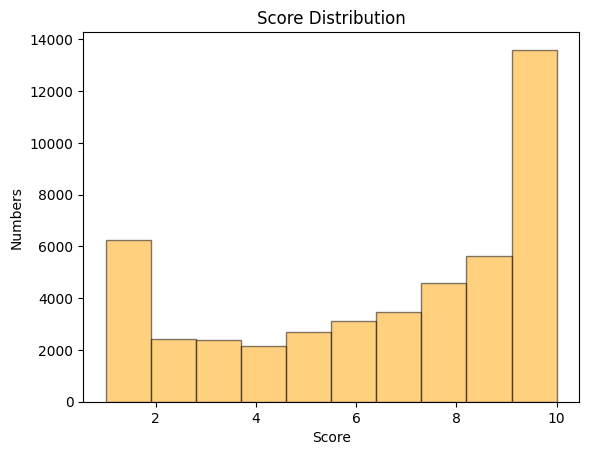

In [2]:
# visualize the distribution of the scores
import matplotlib.pyplot as plt

plot = df["score"].plot.hist(bins=10, alpha=0.5, color="orange", edgecolor="black")
plot.set_xlabel("Score")
plot.set_ylabel("Numbers")
plot.set_title("Score Distribution")
plt.show()